# Swarm Intelligence - RB414 - February 2025
## Eng. Ahmed Métwalli
## Week 2 - ACO

https://pythonhosted.org/inspyred/examples.html#ant-colony-optimization

In [1]:
import numpy
import scipy
import sympy
import networkx
import matplotlib.pyplot as plt
import pymoo
import pyswarms
import inspyred
import deap
import niapy
import pybullet
import ray
import dask

print("All libraries are okay")


All libraries are okay


- We are going to use Inspyred as it offers the following:
    - High-Level Framework for Metaheuristics
        - Built-in Algorithms
        - Benchmarks
    - Reusability and Modularity
        - Components-based design
    - Integration with other libraries/framework

Q&A:

- What is the objective so far?
    - Building the ACS with benchmark (TSP) to get the minimum distance for routing
- Assignments (9/3/2025) - Exam 7th
- Where are we?
    - Initialize Swarm
        - Variables:
            - Attribute: Points (nodes)
            - Weights (distance) (List generator from the points)
        - Steps:
            - problem (benchmarks of TSP(weights))
            - ACS system (swarm.ACS(prng, problem))
            - ACS terminator (maximum generation)
        - Return:
            - ACS system
            - problem
    - Fitness Evaluation:
        - Step:
            - problem.evaluator (evaluation)
    - Communication:
        - Placeholder

Iteration 1: Best so far = 1636.72
Iteration 2: Best so far = 1566.14
Iteration 3: Best so far = 1566.14
Iteration 4: Best so far = 1566.14
Iteration 5: Best so far = 1566.14
Iteration 6: Best so far = 1566.14
Iteration 7: Best so far = 1566.14
Iteration 8: Best so far = 1566.14
Iteration 9: Best so far = 1566.14
Iteration 10: Best so far = 1566.14
Iteration 11: Best so far = 1566.14
Iteration 12: Best so far = 1566.14
No significant improvement detected for 10 iterations; stopping early.
Best Solution (city coordinates in tour order):
(306.0, 360.0)
(283.0, 379.0)
(157.0, 443.0)
(161.0, 280.0)
(110.0, 225.0)
(343.0, 110.0)
(552.0, 199.0)
(490.0, 285.0)
(397.0, 566.0)
(325.0, 554.0)
Tour Distance: 1566.14


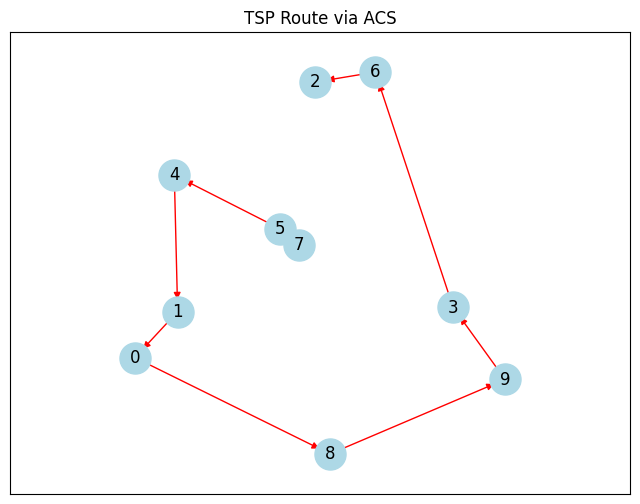

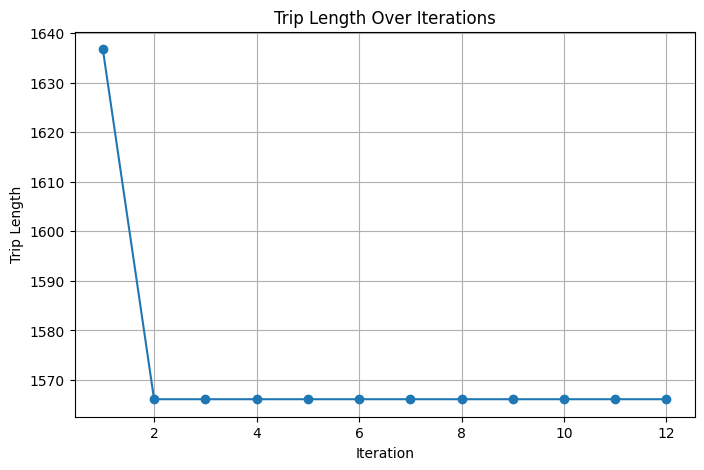

Logged trip lengths: [1636.7222462972777, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365, 1566.1363051360365]


In [ ]:
from random import Random
from time import time
import math
from inspyred import benchmarks, ec, swarm # Benchmark (classes for several problems)
import networkx as nx
import matplotlib.pyplot as plt

###############################################################################
# STEP 1: Initialize Swarm
###############################################################################
def initialize_swarm(prng, points): # Points as a list of points (nodes or cities)
    """
    1. Initialize Swarm
       - Define the problem (TSP).
       - Compute the distance matrix.
       - Instantiate the ACS object with relevant parameters.
       - Params: prng => Pseudo-random number generator, points => A list of the coordinates
    """
    num_points = len(points)
    # Compute the distance matrix (Euclidean distances).
    # Goal: Construct a 2D matrix (weights) of distances between every pair of points (p, q).
    weights = [[math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2) # p[0] and q[0] are the x-coordinates of 2 different points, and p[1] and q[1] are the y-coordinates
                for q in points] for p in points] # Distance Weights
    
    # Inspyred has built-in benchmark classes for common problems like TSP.
    # Here, we create a TSP object, passing it the weights (distance matrix).
    # Why: This problem object knows how to:
    # Construct solutions (problem.constructor),
    # Evaluate solutions (problem.evaluator) using the distance matrix,
    # Possibly handle bounding (problem.bounder),
    problem = benchmarks.TSP(weights) # Initialize TSP problem given our weights weights
    # Weights was distance weights
    # Instantiate ACS with the TSP components.
    acs = swarm.ACS(prng, problem.components) # prng, problem components (phermone)
    # problem.components: This is a structure provided by the TcSP problem that ACS uses to build solutions. Essentially, it gives ACS the “building blocks” for routes.
    # (We keep the default terminator; we will run one generation at a time.)
    # By setting acs.terminator = inspyred.ec.terminators.generation_termination, we say “Stop after a certain number of generations (iterations).”
    acs.terminator = ec.terminators.generation_termination
    return acs, problem

###############################################################################
# STEP 2: Evaluate Fitness (optional)
###############################################################################
def evaluate_fitness(problem, candidate):
    """
    2. Evaluate Fitness
       - The inspyred TSP benchmark includes a built-in evaluator.
       - This function shows how to call it explicitly, if needed.
    """
    return problem.evaluator(candidate) # Fitness values after evaluation

###############################################################################
# STEP 3: Communication (placeholder)
###############################################################################
def communication(acs):
    """
    3. Communication
       - In ACS, ants communicate indirectly via pheromone updates.
       - The evolve() method in inspyred handles pheromone updates internally.
       - This placeholder clarifies where that step occurs logically.
    """
    pass # Information (pheronome and distance) communication

###############################################################################
# STEP 4: Update or Manual Evolution Loop Logging Trip Length
def manual_evolve(acs,
                  problem,
                  iterations=50,
                  pop_size=10,
                  tolerance=1e-3, # Range of error
                  patience=10):
    """
    4. Update or Manual Evolution Loop
        - In ACS, this step is effectively the 'evolve' call, where ants build solutions, deposit pheromones, etc.
        - Params: 
            - acs: Your ACS instance.
            - problem: The TSP problem instance.
            - iterations: Maximum number of iterations (default 50).
            - pop_size: Number of ants (population size) used each iteration.
            - tolerance: The minimum improvement (in distance) required to reset the stagnation counter.
            - patience: Maximum consecutive iterations allowed with no significant improvement.
    """
    trip_lengths = [] # To store trip lengths for logging purposes and plotting iteration over distance.
    best_distance_so_far = float('inf') # Storing the best distance so far starting from infinity
    no_improvement_count = 0  # Counter for consecutive iterations with no significant improvement
    
    for i in range(iterations): # We already have fitness function (problem.evaluator called in def evaluate_fitness) and then we utlize it here for Communication and update
        # Run a single generation (1 iteration)
        acs.evolve(
            # Generator: Produces new candidate solutions.
            # Evaluator: Assesses how good each solution is.
            # Bounder: Keeps solutions within the defined constraints.
            # Maximize: Sets the optimization goal (maximizing fitness, where fitness is defined as the inverse of tour distance).
            # Population Size: Determines how many candidates (ants) are generated per generation.
            # Max Generations: Running one generation at a time enables you to monitor progress and implement early stopping.
            generator=problem.constructor, # This function randomly constructs a valid tour (in our case a sequence of cities).
            evaluator=problem.evaluator, # For the TSP, problem.evaluator calculates the total distance of the tour.
            bounder=problem.bounder, # While TSP solutions naturally must visit each city exactly once, the bounder ensures that any candidate generated remains within the problem’s limits (if applicable)
            maximize=problem.maximize, # the TSP benchmark transforms the problem so that fitness is the reciprocal of the tour length.
            pop_size=pop_size, # Ants
            max_generations=1 # Due to the for loop we already provided the number of iterations earlier.
        )
        
        # Get the best current individual from the archive
        best_current = max(acs.archive, key=lambda ind: ind.fitness) # Finds the individual with the highest fitness. (takes an individual (ind) and returns its fitness attribute. It tells max() to compare individuals based on their fitness.)
        current_distance = 1 / best_current.fitness # Since fitness is the reciprocal of distance, 1/fitness gives the actual trip length.
        
        # Check if the improvement is significant
        if current_distance < best_distance_so_far - tolerance:
            best_distance_so_far = current_distance
            no_improvement_count = 0  # Reset counter on improvement
        else:
            no_improvement_count += 1  # Increment if no significant improvement
        
        # Log the best-so-far distance
        trip_lengths.append(best_distance_so_far)
        print(f"Iteration {i+1}: Best so far = {best_distance_so_far:.2f}")
        
        # Early stopping: if no improvement for 'patience' iterations, break out
        if no_improvement_count >= patience:
            print("No significant improvement detected for", patience, "iterations; stopping early.")
            break
            
    return trip_lengths



###############################################################################
# STEP 5: Meet Termination Conditions (placeholder)
###############################################################################
def meet_termination_conditions(acs):
    """
    5. Meet Termination Conditions
       - In inspyred ACS, the terminator is already set to generation_termination.
       - This placeholder indicates where we would check if we should stop.
    """
    pass

###############################################################################
# STEP 6: End - Display Final Solution and Plot Route
###############################################################################
def display_solution(acs, points):
    """
    6. End
       - Process and display the final solution once the termination conditions are met.
       - We also plot the best TSP route using NetworkX and matplotlib.
    """
    best = max(acs.archive, key=lambda ind: ind.fitness)
    print("Best Solution (city coordinates in tour order):")
    # Reconstruct the route from candidate objects.
    route = [obj.element[0] for obj in best.candidate]
    # Append closing edge (back to the start).
    route.append(best.candidate[-1].element[1])
    
    for idx in route:
        print(points[idx])
    
    distance = 1 / best.fitness
    print("Tour Distance: {:.2f}".format(distance))
    plot_route(points, route)

def plot_route(points, route):
    """
    Visualize the TSP route using NetworkX.
    """
    G = nx.DiGraph()
    # Add nodes.
    for i, coord in enumerate(points):
        G.add_node(i, pos=coord)
    # Add edges according to route.
    for i in range(len(route) - 1):
        G.add_edge(route[i], route[i+1])
    
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='red', arrows=True)
    plt.title("TSP Route via ACS")
    plt.axis('equal')
    plt.show()

def plot_trip_length(trip_lengths): # New Func
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(trip_lengths) + 1), trip_lengths, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Trip Length')
    plt.title('Trip Length Over Iterations')
    plt.grid(True)
    plt.show()

###############################################################################
# Main Function: Assembles the Steps
###############################################################################

prng = Random()
prng.seed(time())

# Define city coordinates.
points = [
    (110.0, 225.0), (161.0, 280.0), (325.0, 554.0), (490.0, 285.0),
    (157.0, 443.0), (283.0, 379.0), (397.0, 566.0), (306.0, 360.0),
    (343.0, 110.0), (552.0, 199.0)
] # 10 Nodes/Cities

# 1. Initialize Swarm.
acs, problem = initialize_swarm(prng, points) # Ant Colony System - Problem

# 2. (Optional) Evaluate Fitness.
sample_candidate = problem.constructor(prng, {'num_nodes': len(points)})
sample_fitness = evaluate_fitness(problem, sample_candidate)
print("Sample Candidate Fitness:", sample_fitness)

# 3. Communication (placeholder).
communication(acs)

# 4. Update/Run Manual Evolution to log trip lengths.
trip_lengths = manual_evolve(acs, problem, iterations=50, pop_size=10)

# 5. Termination Conditions (placeholder).
meet_termination_conditions(acs)

# 6. End: display final solution and plot.
display_solution(acs, points)
plot_trip_length(trip_lengths)
print("Logged trip lengths:", trip_lengths)

In [ ]:
## package ros with cmake list
## catkin_make
## chmod +x filename (py)
## rosrun swarm_intelligence swarm_intelligence_nodemht54

# [View Section 2: Overview of SI](SecWeek2.pdf) 